# MyTorch Master Benchmark: Complete Analysis

This notebook performs a comprehensive visual analysis of the **MyTorch** framework, crossing 5 Datasets, 3 Optimizers, and 4 Activation Functions.

## Experiment Dimensions
- **Datasets**: Moons, Circles, Blobs, Spiral, Noisy Moons.
- **Optimizers**: SGD, Momentum, Adam.
- **Activations**: ReLU, GeLU, Sigmoid, Tanh.
- **Output**: All configurations utilize a final **Softmax** layer for classification.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time, sys, os
from sklearn.datasets import make_moons, make_circles, make_blobs

SEED = 245573
np.random.seed(SEED)
sys.path.append(os.getcwd())

from mytorch.nn import Sequential, Linear, GeLU, ReLU, Sigmoid, Tanh, CrossEntropyLoss
from mytorch.optim import SGD, Adam

print(f"Environment Ready. Seed set to {SEED}. Analyzing 60 combinations.")

Environment Ready. Seed set to 245573. Analyzing 60 combinations.


In [2]:
def generate_spiral(n=300, noise=0.3):
    t = np.sqrt(np.random.rand(n, 1)) * 780 * (2 * np.pi) / 360
    dx = -np.cos(t) * t + np.random.randn(n, 1) * noise
    dy = np.sin(t) * t + np.random.randn(n, 1) * noise
    return np.vstack((np.hstack((dx, dy)), np.hstack((-dx, -dy)))), np.hstack((np.zeros(n), np.ones(n))).astype(int)

datasets = {
    "Moons": make_moons(n_samples=300, noise=0.15, random_state=SEED),
    "Circles": make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=SEED),
    "Blobs": make_blobs(n_samples=300, centers=2, cluster_std=1.2, random_state=SEED),
    "Spiral": generate_spiral(n=200),
    "Noisy": make_moons(n_samples=300, noise=0.3, random_state=SEED)
}

def train_and_get_boundary(model, optimizer, X, y, epochs=250):
    criterion = CrossEntropyLoss()
    Y_oh = np.eye(2)[y]
    for _ in range(epochs):
        # El orden correcto de MyTorch:
        out = model.forward(X)
        _ = criterion.forward(out, Y_oh)
        grad = criterion.backward()
        model.backward(grad)
        
        optimizer.step()
        optimizer.zero_grad()
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = np.argmax(model.forward(np.c_[xx.ravel(), yy.ravel()]), axis=1).reshape(xx.shape)
    return xx, yy, Z

## Visualizing the Decision Boundaries
Each grid below corresponds to one dataset, comparing across Optimizers (rows) and Activations (columns).

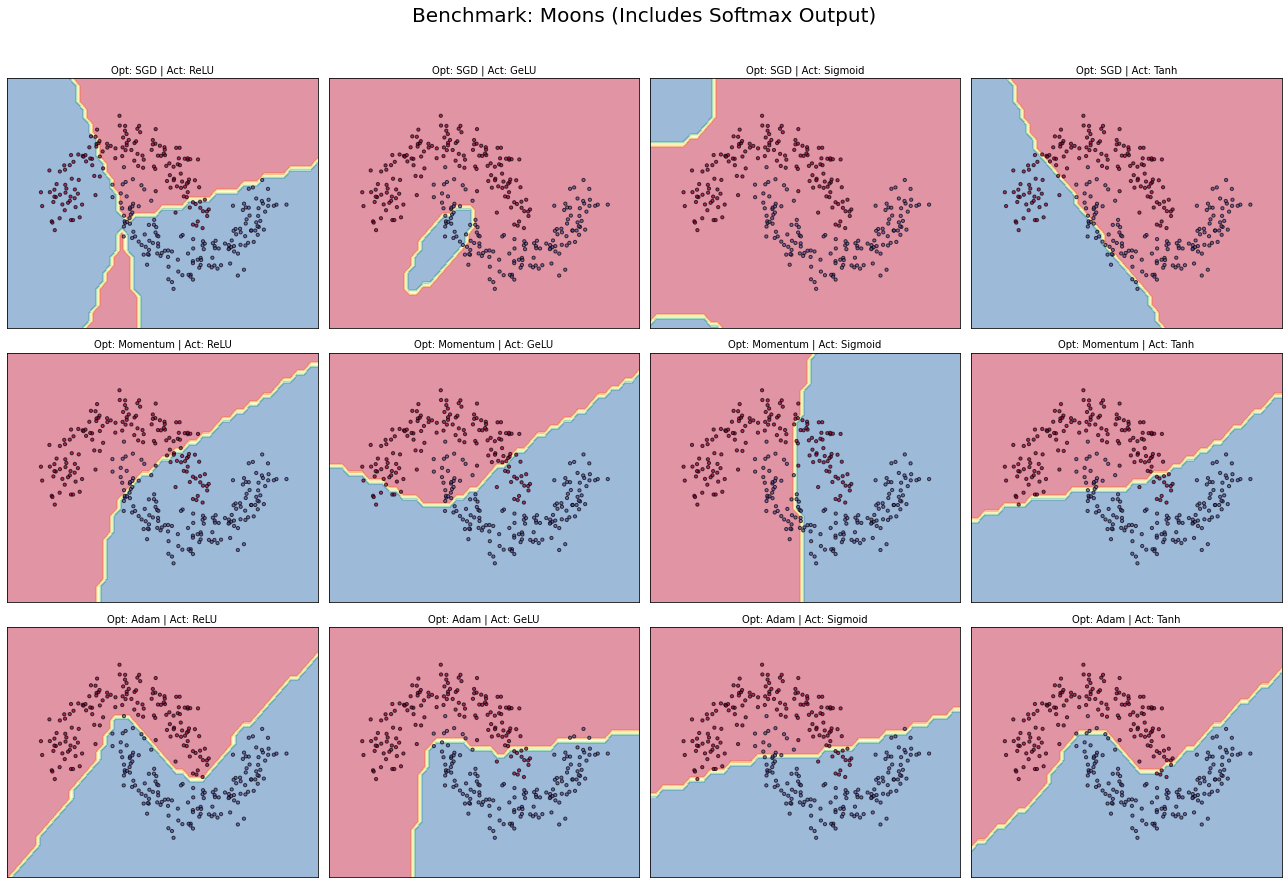

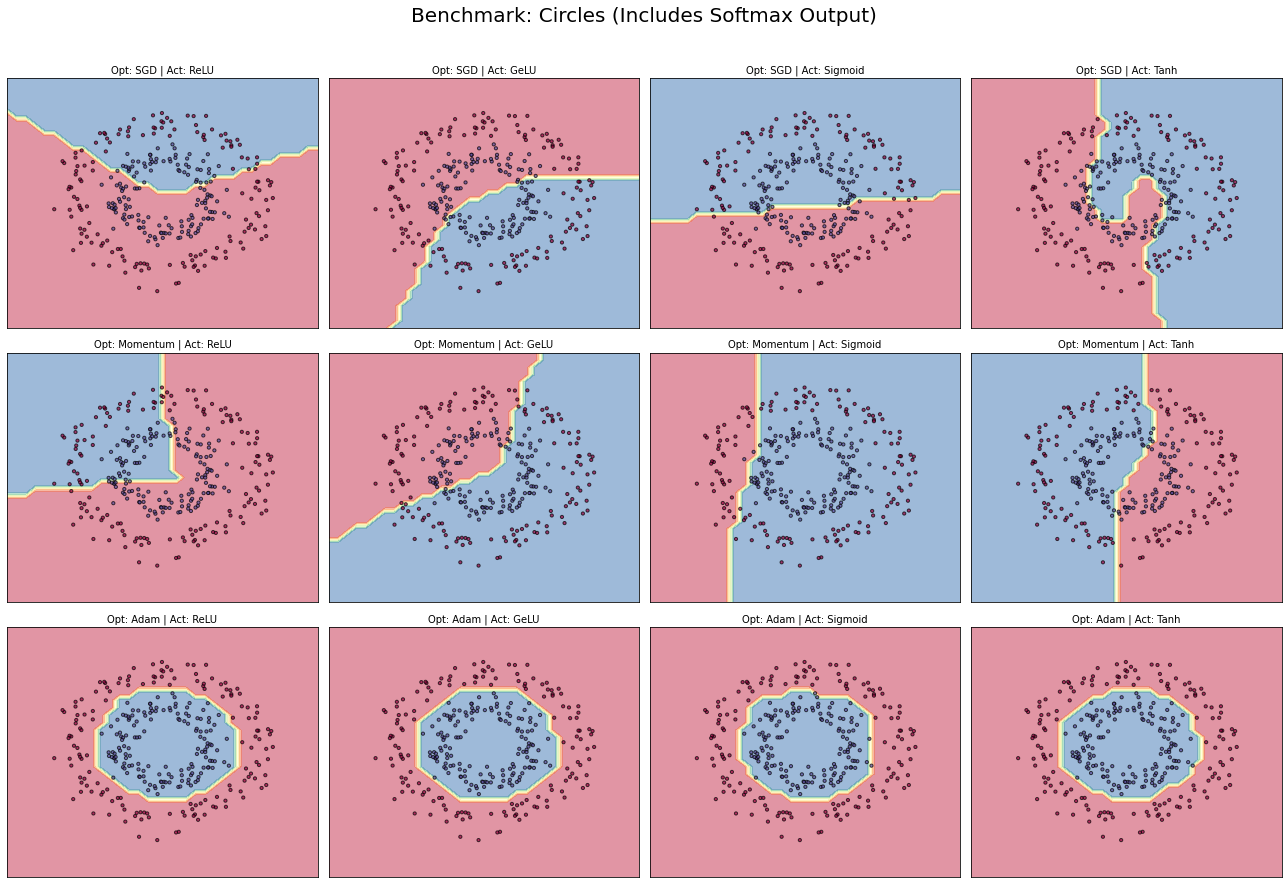

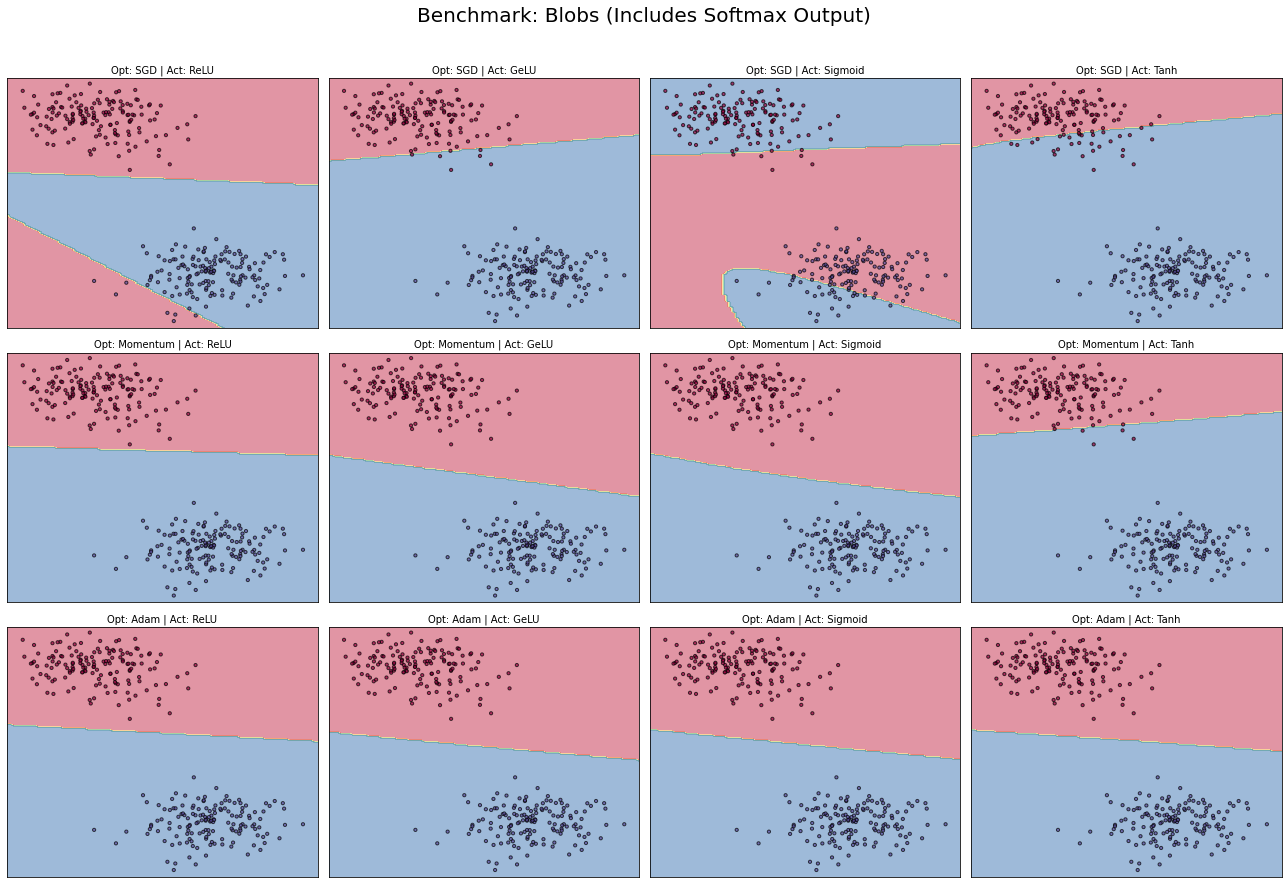

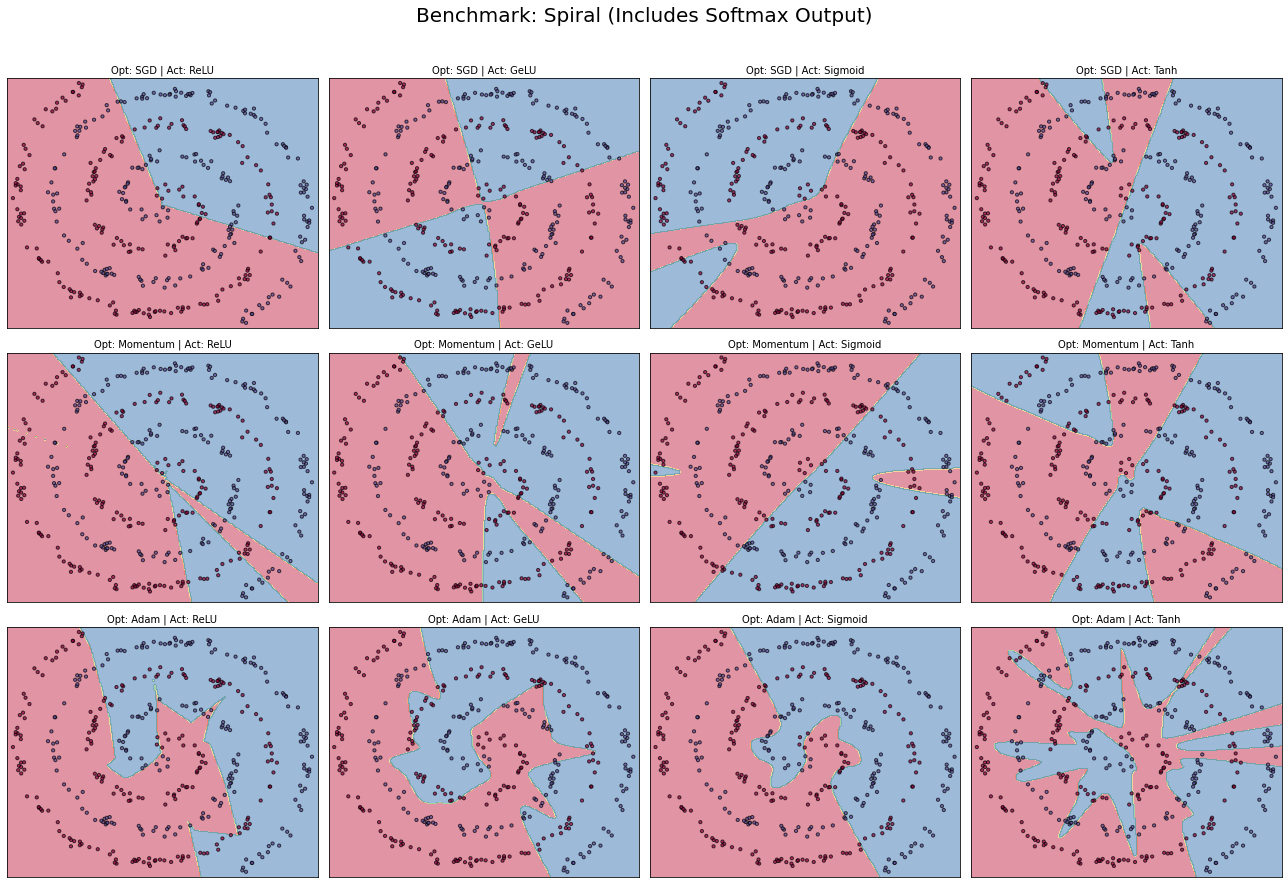

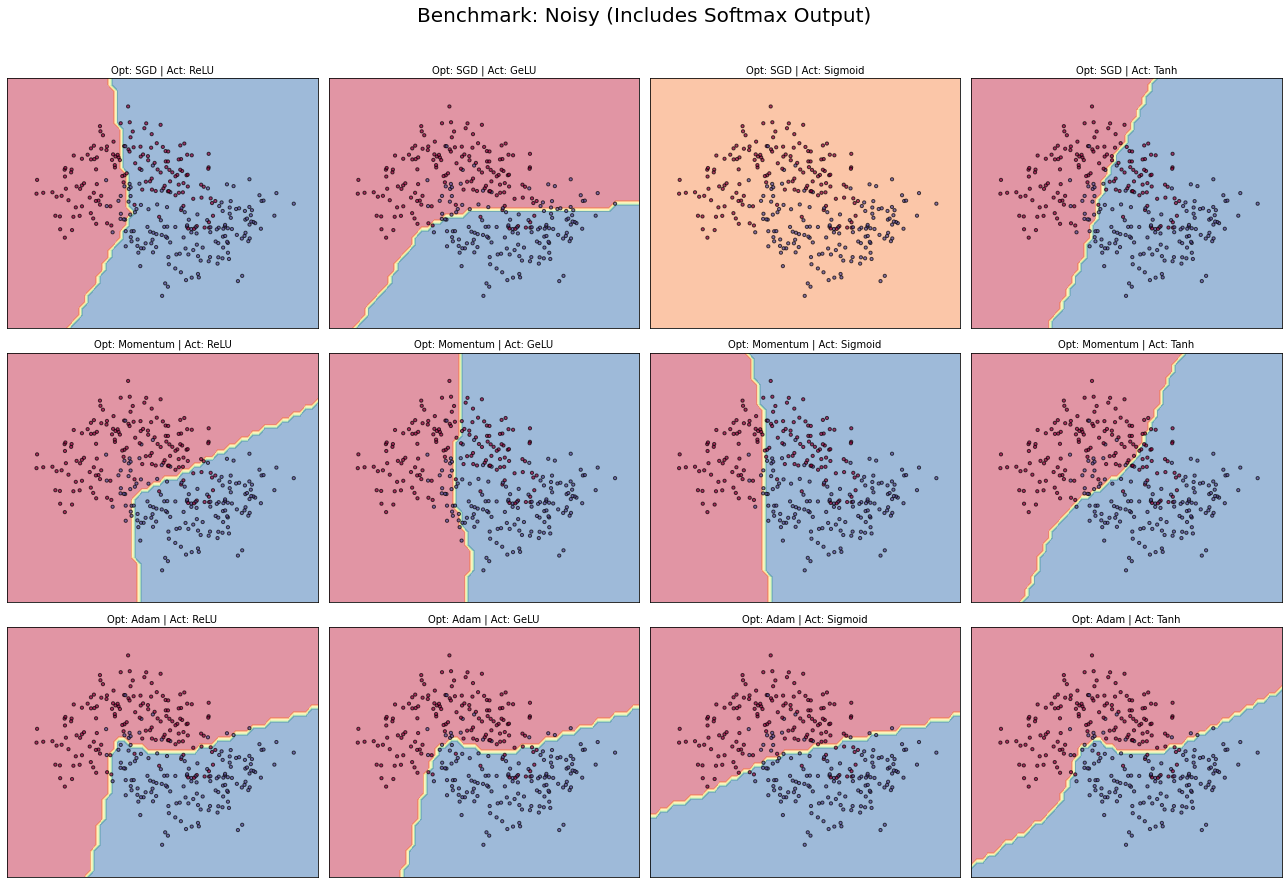

In [3]:
opts_def = [("SGD", lambda m: SGD(m, lr=0.1)), ("Momentum", lambda m: SGD(m, lr=0.1, momentum=0.9)), ("Adam", lambda m: Adam(m, lr=0.01))]
acts_def = [("ReLU", ReLU), ("GeLU", GeLU), ("Sigmoid", Sigmoid), ("Tanh", Tanh)]

for d_name, (X, y) in datasets.items():
    fig, axes = plt.subplots(3, 4, figsize=(18, 12))
    plt.suptitle(f"Benchmark: {d_name} (Includes Softmax Output)", fontsize=20, y=1.02)
    for r, (o_name, o_fn) in enumerate(opts_def):
        for c, (a_name, a_cls) in enumerate(acts_def):
            model = Sequential(Linear(2, 16), a_cls(), Linear(16, 2))
            xx, yy, Z = train_and_get_boundary(model, o_fn(model), X, y)
            ax = axes[r, c]
            ax.contourf(xx, yy, Z, alpha=0.5, cmap='Spectral')
            ax.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='Spectral', edgecolors='k', alpha=0.7)
            ax.set_title(f"Opt: {o_name} | Act: {a_name}", fontsize=10)
            ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()